# Split Neural Network (SplitNN)

Traditionally, PySyft has been used to facilitate federated learning. However, we can also leverage the tools included in this framework to implement distributed neural networks. 

### What is a SplitNN?

<img src="images/anatomy.png" width="50%">

The training of a neural network (NN) is 'split' accross a chain of multiple hosts. Each segment in the chain is a self contained NN that feeds into the segment in front. The host with the training data has the beginning segment of the network and the end segment. Intermediate segments of the chain are held by participating hosts.

### Training Process

The SplitNN network is assembled as a chain of NNs, each feeding into the next. The data subject has both the beginning and the end of this chain.

<img src="images/training.png" width="80%">

When forward propogation commences, the data subject propogates the x values forward through the network at the start of the chain and sends their activation signals to the next intermediate host. This host feeds the recieved activation signal forward through their network and to the next link in the chain. This continues until the end of the chain is reached. The data subject then recieves an activation signal and forward propogates. They then compute the loss using their y-values.

They backward propogate the gradients of the activation signals they recieved to the host previous to them in the chain. This host then computes their gradients, sending the gradient of the activeation signal backward. Eventually, the data subject recieves the gradients of their activation signal at the start of the chain and computes gradients. 

The NNs in the chain update their weights and biases, commenceing the next epoch. When a host is finished training, they pass the front and end segments to the next person with data to train.

<img src="images/BatchFlow.png" width="40%">


### Why use a SplitNN?

The SplitNN has been shown to provide a dramatic reduction in computational burden while maintaining higher accuracies when training over large number of clients [[1](https://arxiv.org/abs/1812.00564)]. In the figure below, the Blue line denotes distributed deep learning using splitNN, red line indicate federated learning (FL) and green line indicates Large Batch Stochastic Gradient Descent (LBSGD).

<img src="images/AccuracyvsFlops.png" width="60%">

<img src="images/computation.png" width="40%">
 
Table 1 shows computational resources consumed when training CIFAR 10 over VGG. Theses are a fraction of the resources of FL and LBSGD. Table 2 shows the bandwith usage when training CIFAR 100 over ResNet. Federated learning is less bandwidth intensive with fewer than 100 clients. However, the SplitNN outperforms other approaches as the number of clients grow[[1](https://arxiv.org/abs/1812.00564)].

<img src="images/bandwidth.png" width="40%">

Using this technique, nobody knows the input data and labels apart from the data subject. All that is sent or recieved between nodes is activation signals during forward propogation and their corresponding gradients during backpropogation. Entropy can be added to the activation signals through adding layers to the model segments. Entropy of training data could potentially be measured to arrive at the appropriate number of layers to use in order to adequately hide the orignal values in start and end segments.

During this process, no hosts involved in the learning process have a full picture of the network. As a result there is very little risk of the model being stolen by participating hosts. Models could only be fully recovered by malicious participants if they were to collude with every other host. 

### Advantages

- The accuracy should be almost identical to a non-split version of the same model, trained locally. 
- Models and data can be homomorphically encrypted for added security at the cost of added computation.
- Model is distributed, meaning all segment holders must conset to the model being aggregated.
- The scalability of this approach, in terms of both network and computational resources, could make this an a valid alternative to FL and LBSGD, particularly on low power devices.
- Could be an effective mechanism for both horizontal and vertical data distributions.
- As computational cost is already quite low, proportianate homomorphic encryption cost is also minimised.

### Constraints

- A new technique with little surroundung literature, a large amount of compartison and evaluation is still to be done.
- This approach requires all hosts to remain online during the entire learning process.
    - makes approach less fesible for hand-held devices
- Less established in toolkits than FL and LBSGD
- While most aspects of the learning process are anonymised, the intermediary hosts are need to know the location of those ahead and behind to send and recieve data during learning. Ideally this would provide anonymity to participants.

### Tutorial 

The SpliNN has the capacity to be a significant contribution to the growing ecosystem of privacy preserving learning methodologies. This tutorial has two purposes;

- To explain in as clear terms as possible what is going on during the training of a SplitNN.
- To provide a working example of a SplitNN learning on arbitrary sets of; training data, model segments and data providers.
- To provide an implementation of this technique on the PySyft framework so that this can be further validated against other techniques. 

### Future work

- Add homomorphic encryption
- A tokenisation infrastructure or masked dns service could be implemented to provide anonymity to hosts during traing. Ideally the difference 'chains' involved here could be written to a smart contract and be publicly available information. 

Authors:
- Adam Hall - Twitter: [@AJH4LL](https://twitter.com/AJH4LL)


# Section 1.1 - A Toy NN Example

<img src="images/wholeNetwork.png" width="60%">


We will begin by training a normal model to benchmark our SplitNN against. This will be the exact same specification as the SPlitNN onlt not distributed. In order to get as close as possible, we will use the same random seed for intitialisation. The dataset will take in a simple (AND AND AND) function. The only x instance with a y value that is 1 will be 1111.

<img src="images/benchmarkExample.png" width="60%">

We will create three identical datasets to simulate the batches for each data owner.

<img src="images/identicalDatasets.png" width="40%">




In [1]:
import torch
from torch import nn
from torch import optim
from torchviz import make_dot, make_dot_from_trace
from torch.autograd import Variable
import time

In [2]:
# A Toy Dataset
x = torch.tensor([[0,0,0],[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1],[1,1,1.]])
y = torch.tensor([[0],[0],[0],[0],[0],[0],[1],[1.]])



x1 = x
x2 = x
x3 = x

y1 = y
y2 = y
y3 = y


torch.manual_seed(1)
# One Model
model = nn.Sequential(
            nn.Linear(3, 3),
            nn.Tanh(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 2),
            nn.Tanh(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

## Model Summary

Here we see the parameter values for our model and the computation graph.

<img src="images/wholeNetwork.png" width="60%">

### Model Parameters

In [3]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

0.weight tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803]])
0.bias tensor([-0.0707,  0.1601,  0.0285])
2.weight tensor([[ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150]])
2.bias tensor([-0.3487, -0.0968, -0.2490])
4.weight tensor([[-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579],
        [ 0.1613,  0.5476,  0.3811]])
4.bias tensor([-0.5260, -0.5489, -0.2785])
6.weight tensor([[ 0.5070, -0.0962,  0.2471],
        [-0.2683,  0.5665, -0.2443]])
6.bias tensor([0.4330, 0.0068])
8.weight tensor([[-0.3725,  0.3635]])
8.bias tensor([-0.3753])


### Computation Graph

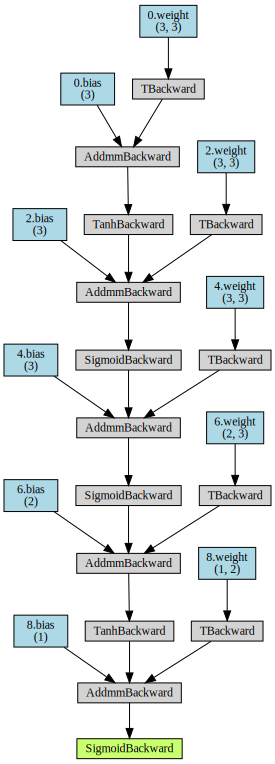

In [4]:
make_dot(model(x), params=dict(model.named_parameters()))

## Training Logic

<img src="images/benchmarkExample.png" width="60%">

In [5]:
def train(x, y):
    # Training Logic
    
    epochs = 200
    learnRate = 0.3
    
    opt = optim.SGD(params=model.parameters(),lr=learnRate)
    counter = 0
    startTime = time.time()
    
    for iter in range(epochs):

        # 1) erase previous gradients (if they exist)
        opt.zero_grad()

        # 2) make a prediction
        pred = model(x)

        # 3) calculate how much we missed
        loss = ((pred - y)**2).sum()

        # 4) figure out which weights caused us to miss
        loss.backward()

        # 5) change those weights
        opt.step()

        # 6) print our progress every 20 epochs
        counter = counter+1
        if counter%(epochs/10) == 0:
            print("Predictions: ",torch.t(pred.data))
            print("Loss: ",loss.data)
            print("Runtime: ",time.time() - startTime)

In [6]:
train(x1, y1)
print("\n\nNEXT BATCH\n\n")
train(x2, y2)
print("\n\nNEXT BATCH\n\n")
train(x3, y3)
print("\n\nFinal Predictions:", torch.t(model(x)))


Predictions:  tensor([[0.2499, 0.2496, 0.2504, 0.2498, 0.2501, 0.2495, 0.2502, 0.2500]])
Loss:  tensor(1.4994)
Runtime:  0.03667902946472168
Predictions:  tensor([[0.2499, 0.2495, 0.2504, 0.2497, 0.2501, 0.2494, 0.2503, 0.2499]])
Loss:  tensor(1.4992)
Runtime:  0.05476498603820801
Predictions:  tensor([[0.2498, 0.2495, 0.2505, 0.2497, 0.2501, 0.2494, 0.2503, 0.2500]])
Loss:  tensor(1.4990)
Runtime:  0.07874083518981934
Predictions:  tensor([[0.2498, 0.2494, 0.2505, 0.2497, 0.2501, 0.2493, 0.2504, 0.2500]])
Loss:  tensor(1.4988)
Runtime:  0.09106302261352539
Predictions:  tensor([[0.2498, 0.2493, 0.2506, 0.2497, 0.2502, 0.2493, 0.2505, 0.2501]])
Loss:  tensor(1.4986)
Runtime:  0.10725808143615723
Predictions:  tensor([[0.2498, 0.2492, 0.2507, 0.2497, 0.2502, 0.2492, 0.2506, 0.2501]])
Loss:  tensor(1.4983)
Runtime:  0.12170886993408203
Predictions:  tensor([[0.2497, 0.2491, 0.2509, 0.2497, 0.2502, 0.2491, 0.2508, 0.2502]])
Loss:  tensor(1.4979)
Runtime:  0.13785386085510254
Predictions: 

# Section 2.1 - A Distributed Training Example

We will train a splitNN model that has been distributed to three different hosts. One host, Alice, is the data subject. Alice has the labelled data and will also be the custodian of the network start and end segments. Claire and Bob are worker hosts. They will feed the activation signals from the start of the chain forward until it reaches alices end layer. They will do the reverse with gradients in the backpropogation process. 

## Section 2.1.1 - Set up environmental variables

Here we will import our required libraries and initialise our model segments and data. We will need;

<img src="images/distributed.png" width="50%">

- A dummy distributed dataset
- 5 model segments
- 3 Virtual Workers

In [7]:
import torch
from torch import nn
from torch import optim
import syft as sy
hook = sy.TorchHook(torch)

from torchviz import make_dot, make_dot_from_trace
from torch.autograd import Variable

In [8]:
# A Toy Dataset
x = torch.tensor([[0,0,0],[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1],[1,1,1.]])
y = torch.tensor([[0],[0],[0],[0],[0],[0],[1],[1.]])


torch.manual_seed(1)
# Five Linked Models
model1 = nn.Sequential(
            nn.Linear(3, 3),
            nn.Tanh()
        )

model2 = nn.Sequential(
            nn.Linear(3, 3),
            nn.Sigmoid()
        )

model3 = nn.Sequential(
            nn.Linear(3, 3),
            nn.Sigmoid()
        )

model4 = nn.Sequential(
            nn.Linear(3, 2),
            nn.Tanh()
        )
model5 = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

# create some workers
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")
claire = sy.VirtualWorker(hook, id="claire")

The final predictions are shown above, we can compare this with the output of the same 'split' neural network

## Section 2.1.2 - Set Environmental environmental variables to Starting Locations

In this example, Alice is the worker with the data and labels. Bob and Claire are intermediary hosts in the chain. Alice has the start and end model segments. Bob and Claire have intermediary segments.

We send the models and data to their respective hosts and store the pointers in associative arrays; the Model Chain (MC) and the xy Chain (xyC). These contain the locations of the data, but no actual values. These are the only necessary parameters for coordinating this learning process. A summary of this is seen below

<img src="images/Parameters.png" width="50%">

In this experiment, the models and data are initialised locally and then distributed out.

In [9]:
# Send Model Segmemnts to starting locations
model1 = model1.send(alice)
model2 = model2.send(alice)
model3 = model3.send(bob)
model4 = model4.send(claire)
model5 = model5.send(alice)

# Distribute the input data
x1 = x.send(alice)
x2 = x.send(bob)
x3 = x.send(claire)

# Distribute the data labels
y1 = y.send(alice)
y2 = y.send(bob)
y3 = y.send(claire)

# Add these values to lists for use in training
xChain = [x1,x2,x3]
yChain = [y1,y2,y3]

xyChain = [xChain,yChain]

dataChain = [xChain, yChain]
# Add these models to a list to be used during training
modelChain = [model1, model2, model3, model4, model5]

## Section 2.1.3 - Forward Propogation

We will need to define the logic of forward and backward propogation. 

Forward propogation feeds the input data into Alice's segment at the beginning of the chain. Alice then sends her activation signal to the location of the next model in the chain. This model propogates this activation and sends it onward to the location of the next segment. The signal will eventually reach alice's end segment to perform a prediction. We store pointers to the activations of each layer using the Activation Chain (AC). This allows us to retrieve the values when processing gradients. When the activations have fully propogated the MC, the method returns the resultant AC for use in the backpropogation function. 

<img src="images/activationchain.png" width="50%">

In [10]:
def forwardPropogate(modelChain, x):

    activationChain = []
    
    activationChain.append(modelChain[0](x))
    activationChain[0] = activationChain[0].get().send(modelChain[1].__getitem__(0).weight[0].location)
    
    i = 1
    for iter in range(len(modelChain)-2):
        activationChain.append(modelChain[i](activationChain[i-1]))
        activationChain[i] = activationChain[i].get().send(modelChain[i+1].__getitem__(0).weight[0].location)
        i += 1

    activationChain.append(modelChain[len(modelChain)-1](activationChain[i-1]))
    
    return activationChain

## Section 2.1.4 - Backward Propogation

The backpropogation function takes the MC, xyC and AC as input parameters.

<img src="images/backpropParams.png" width="80%">


First the backpropogation algorithm computes the loss on Alice's prediction. We use <b>**** what seems to be**** </b> the sum of squared error as our loss function.

<img src="images/loss.png" width="100%">

We then calculate the gradients for the parameters of the end segment using the chain rule.

<img src="images/chainRule.png" width="40%">

This is done automatically for the layers in each segment but we have to recalculate loss for each model segment during the backpropogation phase.

<img src="images/intermediateLoss.png" width="80%">




Each segment feeds the gradients of their activation function back to the segment behind them and updates their weights w.r.t these gradients. This layer computes it's loss by dot joining the original activation signal and it's new gradient. The sum of the result is used to feed back error down the line. After each segment is complete, the optimiser for that model updates. The process is repeated until the segment at the beginning of the chain is reached and alice updates the gradients on her beginning segment.

In [11]:
def backwardPropogate(modelChain, optChain, activationChain, x, y):
        
#   Destroy pre-existing gradient of final layer
    optChain[len(optChain)-1].zero_grad()
    
#     TODO: I DONT KNOW IF ITS NECESSARY TO RECONSTRUCT GRAPH AT EACH LAYER.
#         CAN COMPUTATION GRAPHS EXTEND OVER MODELS ON MULTIPLE HOSTS? AT THE MOMENT
#         I'M JUST FLUSHING THE OLD COMPUTATION GRAPH AND GENERATING A NEW ONE FOR
#         THE PURPOSE OF FEEDING BACK ERROR. THIS IS HIGHLY INEFFICIENT.
#   Constructs computation graph for final layer
    activationChain[len(activationChain)-2].requires_grad = True
    activationChain[len(activationChain)-1] = modelChain[len(modelChain)-1](activationChain[len(activationChain)-2])
    
#     TODO: LOOKS LIKE JUST SQUARED ERROR, NOT MEAN SQUARED. 
#         NOT SURE IF I HAVE THE RIGHT LOSS EQUATION. COULD BE
#         THAT THIS IS DONE AS PART OF THE .SUM() FUNCTION THOUGH?
#         WHEN I ADD THE /n PART IT DOESN'T LEARN SO WELL..
#   Calculates Loss
#     loss = (((activationChain[len(activationChain)-1] - y)**2).sum())/(len(activationChain))
    loss = (((activationChain[len(activationChain)-1] - y)**2).sum())

    
#   Calculates Gradients
    loss.backward()
        
#     for iter in range(len(activationChain)):
#         print(activationChain[iter].location)
    
    
#   End layer sends the gradient of the activation signal back to the layer behind
    DofA = activationChain[len(activationChain)-2].grad.clone().get().send(modelChain[len(modelChain)-2].__getitem__(0).weight[0].location)
    
#   End layer updates weights
    optChain[len(optChain)-1].step()

#   Compute Intermediary Layers
    for iter in range(len(modelChain)-1, 1, -1): 
        optChain[iter-1].zero_grad()
        activationChain[len(activationChain)-iter-1].requires_grad = True
        activationChain[iter-1] = modelChain[iter-1](activationChain[iter-2]) 
        feedbackError = torch.matmul(torch.t(activationChain[iter-1]), DofA).sum()
        feedbackError.backward()
        DofA = activationChain[iter-2].grad.clone().get().send(modelChain[iter-2].__getitem__(0).weight[0].location)
        optChain[iter-1].step()

#   Compute Final Layer 
    optChain[0].zero_grad()
    activationChain[0] = modelChain[0](x) 
    feedbackError = torch.matmul(torch.t(activationChain[0]), DofA).sum()
    feedbackError.backward()
    optChain[0].step()
        
    return activationChain[len(activationChain)-1], loss

## Section 2.1.5 - Run Training Logic

Now we will run the training process over 200 epochs for each data owner. Every 20 epochs we will print our progress. The front and end sections of the model will be swapped between data owners training each individual batch.

<img src="images/BatchFlow.png" width="40%">


In [12]:
def AnonymousSplitNNtrain(modelChain, xyChain):
    
    #   Variables for performance metrics
    startTime = time.time()
    epochs = 200
    learnRate = 0.3
    counter = 0
    
    #   Create optimisers for each segment and link to their segment    
    optChain = [0]*len(modelChain)
    for iter in range(len(modelChain)):
        optChain[iter] = optim.SGD(params=modelChain[iter].parameters(),lr=learnRate)
    
    
    for i in range(len(xyChain[0])):
        
#       Begin work on current data subjecta
        x = xyChain[0][i]
        y = xyChain[1][i]
        
        for iter in range(epochs):
        #   Forward propogate through network until final layer is reached
            activationChain = forwardPropogate(modelChain, x)
            
#             DEBUGGING
#             for iter in range(len(activationChain)):
#                 print(activationChain[iter].location)
            
        #   Backward propogate
            predictions, loss = backwardPropogate(modelChain, optChain, activationChain, x, y)

            counter = counter+1
            if counter%(epochs/10) == 0:
                print("Epoch: ",counter)
                print("Predictions: ",torch.t(predictions).get().data)
                print("Loss: ",loss.get().data)
                print("Runtime: ",time.time() - startTime)
    
        counter = 0
        
#       If we are not at the end of the data owner chain send perimeter segments to next data owner
        if i < len(xyChain[0])-1:
            modelChain[0].get().send(xyChain[0][i+1].location)
            modelChain[len(modelChain)-1].get().send(xyChain[0][i+1].location)      
            

            print("\nNEXT DATA OWNER\n")
            print("MODEL CHAIN LOCATIONS\n")
            for iter in range(len(modelChain)):
                print(modelChain[iter].__getitem__(0).weight[0].location)
                
            print("\n\n")
    
#     Aggregate models back to researcher
    for i in range(len(modelChain)):
        modelChain[i] = modelChain[i].get()
    
#     Perform predictions with update weights
    x = torch.tensor([[0,0,0],[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1],[1,1,1.]])
    for i in range(len(modelChain)):
        x = modelChain[i](x)
        
    print("\n\nFinal Predictions:", torch.t(x))
    

In [13]:
AnonymousSplitNNtrain(modelChain, xyChain)

Epoch:  20
Predictions:  tensor([[0.2504, 0.2502, 0.2508, 0.2502, 0.2506, 0.2501, 0.2506, 0.2504]])
Loss:  tensor(1.4996)
Runtime:  0.7043418884277344
Epoch:  40
Predictions:  tensor([[0.2500, 0.2498, 0.2504, 0.2498, 0.2502, 0.2496, 0.2502, 0.2500]])
Loss:  tensor(1.4995)
Runtime:  1.4386687278747559
Epoch:  60
Predictions:  tensor([[0.2500, 0.2497, 0.2504, 0.2498, 0.2502, 0.2496, 0.2502, 0.2500]])
Loss:  tensor(1.4995)
Runtime:  2.2165539264678955
Epoch:  80
Predictions:  tensor([[0.2500, 0.2497, 0.2504, 0.2498, 0.2502, 0.2496, 0.2503, 0.2500]])
Loss:  tensor(1.4994)
Runtime:  2.9400017261505127
Epoch:  100
Predictions:  tensor([[0.2499, 0.2497, 0.2505, 0.2498, 0.2502, 0.2496, 0.2503, 0.2501]])
Loss:  tensor(1.4993)
Runtime:  3.6466569900512695
Epoch:  120
Predictions:  tensor([[0.2499, 0.2497, 0.2505, 0.2498, 0.2502, 0.2496, 0.2504, 0.2501]])
Loss:  tensor(1.4992)
Runtime:  4.35632586479187
Epoch:  140
Predictions:  tensor([[0.2499, 0.2496, 0.2505, 0.2498, 0.2502, 0.2495, 0.2504, 0.2

### TODO:
- Figure out whether we need to reconstruct computation graph at each layer
- Implement .move() instead of .get().send()
    - Should move data directly between owners
- Connect the model to the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a> using <a href="https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/Part%208%20-%20Introduction%20to%20Plans.ipynb"> this </a> and <a href="https://github.com/blockpass-identity-lab/PySyft/blob/dev/examples/tutorials/Part%206%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb"> this </a> tutorial
    
- Adjust training data / models to match the text/ diagrams. (add 4th dimension)